In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 3
batch_size = 32

train_buf = 60000
test_buf = 10000
batch_size = 3

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Load and prepare the Fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
#(학습 이미지, 학습 레이블), (테스트 이미지, 테스트 레이블)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

# Use tf.data to batch and shuffle the dataset
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
dim_x = np.shape(x_train)[1:]

In [ ]:
class CNN(tf.keras.Model):
  """ A basic cnn class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(CNN, self).__init__()
    self.__dict__.update(kwargs)
    
    # Set network
    self.nn = keras.Sequential(self.nn_desc)

    # Set loss
    self.loss_fn = keras.losses.SparseCategoricalCrossentropy()
      
  def __call__(self, x_in):
    return self.nn(x_in)

  @tf.function
  def compute_loss(self, y_true, y_pred):
    return self.loss_fn(y_true, y_pred)

  def compute_gradients(self, x_in, y_in):
    with tf.GradientTape() as tape:
      y_pred = self.nn(x_in)
      loss_out = self.compute_loss(y_in, y_pred)
      
    cg_out = tape.gradient(loss_out, self.trainable_variables)
    return cg_out, y_pred, loss_out
  
  @tf.function
  def train(self, x_in, y_in):
    """ Trains model. """
    gradients, y_pred, loss_out = self.compute_gradients(x_in, y_in)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    return y_pred, loss_out

In [ ]:
nn_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
           keras.layers.Conv2D(filters=32, kernel_size=2, strides=(1, 1), activation="relu"),
           keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
           keras.layers.Conv2D(filters=32, kernel_size=2, strides=(1, 1), activation="relu"),
           keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
           keras.layers.Flatten(),
           keras.layers.Dense(units=128, activation='relu'),
           keras.layers.Dense(units=10, activation='softmax')]


# Set optimizer
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
cnn = CNN(learning_rate=learning_rate, nn_desc=nn_desc, optimizer=optimizer)

In [ ]:
# Select metrics to measure the loss and the accuracy of the model
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = keras.metrics.Mean(name='test_loss')
test_accuracy = keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch, y_batch in train_data:
    y_pred, loss = cnn.train(x_batch, y_batch)
    train_loss(loss)
    train_accuracy(y_batch, y_pred)


  for x_batch_t, y_batch_t in test_data:
    y_pred_t = cnn(x_batch_t)
    loss_t = cnn.compute_loss(y_batch_t, y_pred_t)
    test_loss(loss_t)
    test_accuracy(y_batch_t, y_pred_t)

  template = 'Epoch {:d}, Loss: {:f}, Accuracy: {:f}, Test Loss: {:f}, Test Accuracy: {:f}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.390947, Accuracy: 85.768333, Test Loss: 0.333193, Test Accuracy: 87.650002
Epoch 2, Loss: 0.277558, Accuracy: 89.760002, Test Loss: 0.298327, Test Accuracy: 89.430000
Epoch 3, Loss: 0.241003, Accuracy: 91.023331, Test Loss: 0.270748, Test Accuracy: 90.029999


In [ ]:
# Select test data
num_test_sel = 4
num_test = x_test.shape[0]
idx_rand = np.random.permutation(np.arange(0, num_test))
idx_rand_sel = idx_rand[0:num_test_sel]

x_sel = x_test[idx_rand_sel, :, :, :]
y_sel = y_test[idx_rand_sel]

y_out = cnn(x_sel)
y_out = y_out.numpy()
y_sel_pred = np.argmax(y_out, axis=1)

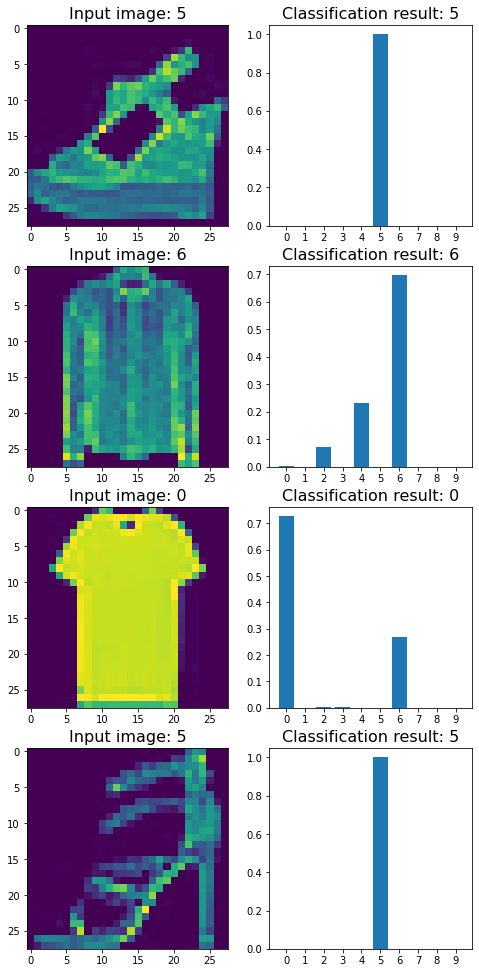

In [ ]:
# Plot test result
import matplotlib.pyplot as plt
from matplotlib import gridspec
barx = np.arange(0,10)

fig = plt.figure(figsize=(8, 4.25 * num_test_sel)) 
gs = gridspec.GridSpec(nrows=num_test_sel,
                       ncols=2,
                       height_ratios=[1]*num_test_sel, 
                       width_ratios=[1, 1]
                       )

for nidx_d in range(0, num_test_sel):
  _x_sel_plot = x_sel[nidx_d, :]
  x_sel_plot = np.reshape(_x_sel_plot, (28, 28))
  y_sel_plot = y_sel[nidx_d]
  y_out_plot = y_out[nidx_d, :]
  y_sel_pred_plot = y_sel_pred[nidx_d]
  ax0 = plt.subplot(gs[nidx_d, 0])
  ax0.imshow(x_sel_plot)
  ax0.title.set_text('Input image: {:d}'.format(y_sel_plot))
  ax0.title.set_fontsize(16)

  ax1 = plt.subplot(gs[nidx_d, 1])
  ax1.bar(barx, y_out_plot.reshape(-1))
  plt.xticks(barx)
  ax1.title.set_text('Classification result: {:d}'.format(y_sel_pred_plot))
  ax1.title.set_fontsize(16)

plt.show()